# BERT做文本分类
BERT做文本分类
1. 使用BERT预训练的encoder 搭配确定的preprocess
2. 将文本经过preprocess转化为id表示
3. 经过encoder 转化为一个向量
4. 之后进行分类即可

In [63]:
import os
import shutil

import tensorflow as tf
from tensorflow.keras import Model
import tensorflow.keras as keras
import tensorflow_hub as hub
import pydot
import graphviz
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

import numpy as np

tf.get_logger().setLevel('ERROR')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 使用 GPU 1
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [7]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)
logical_devices = tf.config.list_logical_devices("GPU")

In [8]:
os.getcwd()

'/home/wy'

In [9]:
data_root_path = './tensorflow_study/bert_exp/data_dir/'

In [10]:
# 下载数据集
if not os.path.exists(data_root_path + 'aclImdb'):

    url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

    dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='./tensorflow_study/bert_exp/',
                                  cache_subdir='data_dir')

    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    train_dir = os.path.join(dataset_dir, 'train')

    # remove unused folders to make it easier to load the data
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [12]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    data_root_path + 'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)
# text_dataset_from_directory 的模式是找到指定目录下的
# main_directory/
#               class_a(pos)/
#                           xxx.txt 作为class a的内容

#               class_b(neg)/
#                           xxx.txt 作为class b的内容

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [13]:
# 分类的名称
raw_train_ds.class_names

['neg', 'pos']

In [14]:
# 将数据集cache化 加载进gpu显存
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# 类似方法处理验证集和测试集

val_ds = tf.keras.utils.text_dataset_from_directory(
    data_root_path + 'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    data_root_path + 'aclImdb/train',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [16]:
# 选择bert模型
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

tfhub_handle_preprocess = tfhub_handle_preprocess.replace('https://tfhub.dev', 'https://hub.tensorflow.google.cn')
tfhub_handle_encoder = tfhub_handle_encoder.replace('https://tfhub.dev', 'https://hub.tensorflow.google.cn')
# 替换成中国区

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3


In [17]:
# 通过bert的地址 获得bert对应的keras模型
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [18]:
text_test = tf.constant(['this is such an amazing movie! I love it.'])
text_preprocessed = bert_preprocess_model(text_test)
text_preprocessed

{'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[ 101, 2023, 2003, 2107, 2019, 6429, 3185,  999, 1045, 2293, 2009,
         1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1,

In [19]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :20]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :20]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :20]}')
# preprocess之后得到三个输出 input_type_ids, input_mask input_word_ids

# 将输入限制在128个token之内
# 值得注意的是自动加了sos->101 eos->102

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999 1045 2293 2009 1012  102    0
    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [21]:
bert_results = bert_model(text_preprocessed)
bert_results

{'default': <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
 array([[ 0.94583553,  0.99236196, -0.04731859,  0.403131  ,  0.03982377,
          0.55926394,  0.9726481 , -0.98114413,  0.11186353, -0.9885572 ,
         -0.007943  , -0.9915898 ,  0.51591676, -0.99976724,  0.23134291,
          0.56714445,  0.02372164,  0.28877968, -0.5466042 , -0.3921279 ,
          0.28494704, -0.093316  , -0.94514793, -0.33993337,  0.99549043,
          0.9918967 , -0.4085013 , -0.279065  ,  0.34103978,  0.998995  ,
          0.57101595, -0.16961594,  0.56449014, -0.25247318,  0.33606845,
          0.00919084, -0.14162496, -0.5767899 , -0.91212845, -0.10437413,
         -0.0187241 ,  0.05135365,  0.26332742, -0.79209185,  0.15561007,
          0.6867801 , -0.985526  ,  0.1390413 ,  0.5991049 , -0.4234864 ,
          0.99840933, -0.2802809 ,  0.9865977 , -0.60577315,  0.77312416,
          0.0169067 , -0.05991882, -0.36237583, -0.99974024, -0.9960342 ,
          0.10039859, -0.22235483,  0.9847399 , -0

In [22]:
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Keys       : {list(bert_results.keys())}')
print(f'default shape:{bert_results["default"].shape}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
print(f'Encoder Outputs Shape:{np.array(bert_results["encoder_outputs"]).shape}')
# pooled_output 将input sequence表示为一个整体 维度是[batch_size, hidden] 这是整个句子的一个embedding
# sequence output 表示了每个token的embedding 维度是[batch_size, seq_len, hidden] 是每个token的embedding
# encoder_output 表示encoder中每个Transformer blocks的中间隐层状态 [block_num, batch_size, seq_len, hidden] block_num代表了transformer encoder的个数
#                encoder_outputs[-1] == sequence_output

Loaded BERT: https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Keys       : ['default', 'pooled_output', 'sequence_output', 'encoder_outputs']
default shape:(1, 512)
Pooled Outputs Shape:(1, 512)
Sequence Outputs Shape:(1, 128, 512)
Encoder Outputs Shape:(4, 1, 128, 512)


In [45]:
class TextClassificationModel(Model):
    def __init__(self, dropout = 0.1):
        super(TextClassificationModel, self).__init__()
        self.dropout = dropout
        self.preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name = 'preprocessing')
        self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name = 'BERT_encoder')
        # 将bert处理后的内容当做embedding进行下游任务
        self.dropout_layer = keras.layers.Dropout(self.dropout)
        self.output_proj = keras.layers.Dense(units=1, activation=None, name='classifier')

    def call(self, inputs, training=None, mask=None):
        # [batch, seq_len] seq_len是不同句子的长度

        preprocessed = self.preprocessing_layer(inputs)
        # 包含了input_word_ids input_type_ids input_mask 每个维度都是[batch, max_seq_len] padding过了
        encoded = self.encoder(preprocessed)
        # 包含了pooled_output encoder_outputs sequence_output
        x = encoded['pooled_output']
        # [batch, hidden] pooled_output将整个句子表示为一个向量 没有seq_len
        x = self.dropout_layer(x)
        y = self.output_proj(x)
        # [batch, 1]
        return y

In [46]:
model = TextClassificationModel(dropout=0.1)

In [47]:
model.inputs = keras.layers.Input(shape=(), dtype=tf.string, name='text')

In [48]:
# test
test_input = tf.constant(["I don't know how to study tensorflow.", "can you teach me?"], dtype=tf.string)
output = model(test_input)

In [49]:
output

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.842085 ],
       [1.5214821]], dtype=float32)>

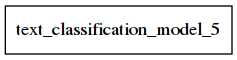

In [50]:
tf.keras.utils.plot_model(model)

In [52]:
loss = keras.losses.BinaryCrossentropy(from_logits=True) # 由于是二分类且最后一层全连接层没有加入激活函数 所以from_logits=True
metrics = keras.metrics.BinaryAccuracy()

In [54]:
# 使用AdamW作为优化器
# 学习率先warmup再进行衰减
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() # 获取数据集的基数???
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps) # 前10%进行warmup

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [55]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [59]:
history = model.fit(x = train_ds, validation_data=val_ds, epochs=epochs) # 用dataset对象做x和validation_data

Epoch 1/5
625/625 [==============================] - 90s 136ms/step - loss: 0.4834 - binary_accuracy: 0.7430 - val_loss: 0.3694 - val_binary_accuracy: 0.8238
Epoch 2/5
625/625 [==============================] - 84s 135ms/step - loss: 0.3240 - binary_accuracy: 0.8558 - val_loss: 0.3876 - val_binary_accuracy: 0.8304
Epoch 3/5
625/625 [==============================] - 85s 135ms/step - loss: 0.2436 - binary_accuracy: 0.8978 - val_loss: 0.3870 - val_binary_accuracy: 0.8494
Epoch 4/5
625/625 [==============================] - 85s 135ms/step - loss: 0.1859 - binary_accuracy: 0.9268 - val_loss: 0.4455 - val_binary_accuracy: 0.8538
Epoch 5/5
625/625 [==============================] - 85s 135ms/step - loss: 0.1426 - binary_accuracy: 0.9461 - val_loss: 0.4832 - val_binary_accuracy: 0.8510


In [60]:
# 测试
loss, accuracy = model.evaluate(x = test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 66s 84ms/step - loss: 0.1647 - binary_accuracy: 0.9473
Loss: 0.16467756032943726
Accuracy: 0.9473199844360352


In [61]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [62]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

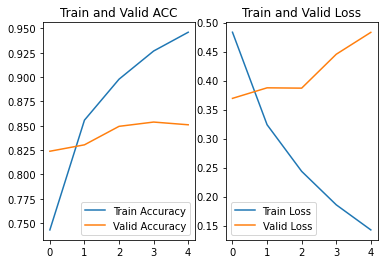

In [64]:
plt.subplot(1,2,1)
plt.plot(acc, label = 'Train Accuracy')
plt.plot(val_acc, label = 'Valid Accuracy')
plt.title('Train and Valid ACC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Valid Loss')
plt.title('Train and Valid Loss')
plt.legend()
plt.show()

'./tensorflow_study/bert_exp/data_dir/'

In [66]:
# 保存模型
dataset_name = 'imdb'
saved_model_path = './tensorflow_study/bert_exp/model_dir/imdb_bert'

model.save(filepath=saved_model_path, include_optimizer=False)

In [67]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [69]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'I think it can make progress',
    'I don\'t want to see it again!',
    'I don\'t want to see it again.'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples))) # 得到概率
original_results = tf.sigmoid(model(tf.constant(examples))) # 得到概率

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999860
input: The movie was great!           : score: 0.997062
input: The movie was meh.             : score: 0.948427
input: The movie was okish.           : score: 0.030093
input: The movie was terrible...      : score: 0.000924
input: I think it can make progress   : score: 0.645539
input: I don't want to see it again!  : score: 0.882844
input: I don't want to see it again.  : score: 0.782646

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999860
input: The movie was great!           : score: 0.997062
input: The movie was meh.             : score: 0.948427
input: The movie was okish.           : score: 0.030093
input: The movie was terrible...      : score: 0.000924
input: I think it can make progress   : score: 0.645539
input: I don't want to see it again!  : score: 0.882844
input: I don't want to see it again.  : score: 0.782646



In [75]:
# tf serving 不是很懂
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['output_1'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999860
input: The movie was great!           : score: 0.997062
input: The movie was meh.             : score: 0.948427
input: The movie was okish.           : score: 0.030093
input: The movie was terrible...      : score: 0.000924
input: I think it can make progress   : score: 0.645539
input: I don't want to see it again!  : score: 0.882844
input: I don't want to see it again.  : score: 0.782646

